In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Import libraries
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.nn.functional import sigmoid, relu
from scipy.cluster.hierarchy import dendrogram, linkage
import os
import time

In [0]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
with open('gdrive/My Drive/Colab Notebooks/items.txt','r') as fid:
    names_items = np.array([l.strip() for l in fid.readlines()])
with open('gdrive/My Drive/Colab Notebooks/relations.txt','r') as fid:
    names_relations = np.array([l.strip() for l in fid.readlines()])
with open('gdrive/My Drive/Colab Notebooks/attributes.txt','r') as fid:
    names_attributes = np.array([l.strip() for l in fid.readlines()])
        
nobj = len(names_items)
nrel = len(names_relations)
nattributes = len(names_attributes)
print('List of items:')
print(names_items)
print("List of relations:")
print(names_relations)
print("List of attributes:")
print(names_attributes)

List of items:
['Beaver' 'Otter' 'Dolphin' 'Trout' 'Flatfish' 'Shark' 'Bear' 'Wolf'
 'Tiger' 'Fox' 'Rabbit' 'Crocodile' 'Snake' 'Bee' 'Butterfly' 'Maple_tree'
 'Oak_tree' 'Palm_tree' 'Pine_tree' 'Willow_tree' 'Orchid' 'Poppy' 'Tulip'
 'Sunflower' 'Rose']
List of relations:
['ISA' 'Is' 'Can' 'Has']
List of attributes:
['Plant' 'Animal' 'Tree' 'Flower' 'Aquatic_animal' 'Land_animal' 'Mammal'
 'Beaver' 'Otter' 'Dolphin' 'Trout' 'Flatfish' 'Shark' 'Bear' 'Wolf'
 'Tiger' 'Fox' 'Rabbit' 'Crocodile' 'Snake' 'Bee' 'Butterfly' 'Maple_tree'
 'Oak_tree' 'Palm_tree' 'Pine_tree' 'Willow_tree' 'Orchid' 'Poppy' 'Tulip'
 'Sunflower' 'Rose' 'Pretty' 'Big' 'Living' 'Green' 'Red' 'Yellow' 'White'
 'Grow' 'Move' 'Swim' 'Fly' 'Walk' 'Growl' 'Leaves' 'Roots' 'Skin' 'Legs'
 'Bark' 'Branches' 'Petals' 'Wings' 'Feathers' 'Scales' 'Gills' 'Fur']


In [0]:
import pickle
infile = open('gdrive/My Drive/Colab Notebooks/Final_dataset','rb')
new_dict = pickle.load(infile)
infile.close()
infile = open('gdrive/My Drive/Colab Notebooks/Final_dataset_test','rb')
test_dict = pickle.load(infile)
infile.close()

(50000, 3072)
(32, 32, 3)


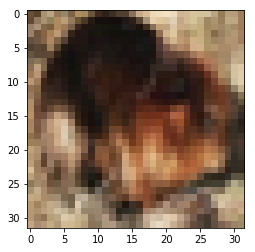

In [0]:
new_dict.keys
print(new_dict['data'].shape)
image1 = (new_dict['data'][1,:].reshape(3,32,32).transpose(1,2,0))
plt.imshow(image1)
print(image1.shape)
image2 = (test_dict['data'][0,:].reshape(3,32,32).transpose(1,2,0))
plt.imshow(image2)

In [0]:
train_images = new_dict['data'].reshape((len(new_dict['data']), 3, 32, 32))
print(train_images.shape)
test_images = test_dict['data'].reshape((len(test_dict['data']), 3, 32, 32))
print(test_images.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)


In [0]:
#means = np.mean(train_images,axis=(0,1,2))/255
#stds = np.std(train_images, axis=(0,1,2))/255
#print(means)
#print(stds)
train_images = train_images/255
test_images = test_images/255

In [0]:
from torchvision import transforms, utils
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_images,dtype=torch.float),torch.tensor(new_dict['label'],dtype=torch.float))
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=300, shuffle=True, num_workers=2)
# get some random training images
#dataiter = iter(trainloader)
#images, labels = dataiter.next()
#labels.shape
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_images,dtype=torch.float),torch.tensor(test_dict['label'],dtype=torch.float))
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)
#dataiter_test = iter(testloader)
#images_test, labels_test = dataiter_test.next()

In [0]:
'''AlexNet for CIFAR10. FC layers are removed. Paddings are adjusted.
Without BN, the start learning rate should be 0.01
(c) YANG, Wei 
'''
import torch.nn as nn

class AlexNet(nn.Module):

    def __init__(self, num_hidden):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_hidden = nn.Linear(256 + 4, num_hidden)
        self.fc_output = nn.Linear(num_hidden, 57)

    def forward(self, x, y):
        x = self.features(x)
        rep = x.view(x.size(0), -1)
        hidden = relu(self.fc_hidden(torch.cat((rep,y),1)))
        output = sigmoid(self.fc_output(hidden))
        return output, hidden, rep



In [0]:
def train(mynet,epoch_count,nepochs_additional=100):
    # Input
    #  mynet : Net class object
    #  epoch_count : (scalar) how many epochs have been completed so far
    #  nepochs_additional : (scalar) how many more epochs we want to run
    mynet.train()
    for e in range(nepochs_additional): # for each epoch      
      error_epoch = 0.
      for batch_idx, (data,target) in enumerate(trainloader):
        t0 = time.time()
        data, target = torch.autograd.Variable(data), torch.autograd.Variable(target)
        data, target = data.cuda(), target.cuda()
        outputs, hidden, rep = mynet(data, target[:,:4])
        loss = criterion(outputs, target[:,4:])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        error_epoch += loss.item()
      print('epoch ' + str(epoch_count+e) + ' loss ' + str(round(error_epoch,3)))
      print('time taken for the epoch ' + str(round((time.time()-t0),3)))
    return epoch_count + nepochs_additional

In [0]:
def get_rep(net):
    # Extract the hidden activations on the Representation Layer for each item
    # 
    # Input
    #  net : Net class object
    #
    # Output
    #  rep : [nitem x rep_size numpy array], where each row is an item
    rep_avg = np.zeros([25,256])
    for idx,(data, target) in enumerate(testloader):
      if idx == 25:
        break
      data, target = torch.autograd.Variable(data), torch.autograd.Variable(target)
      data, target = data.cuda(), target.cuda()
      outputs, hidden, rep = mynet(data, target[:,:4])
      rep_avg[idx,:] = np.mean(rep.cpu().detach().numpy(),axis=0,keepdims=True)
    print(rep_avg.shape)
    return rep_avg

def plot_dendo(rep1,rep2,rep3,names):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using hierarchical clustering
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1,nepochs_phase2,nepochs_phase3]
    linked1 = linkage(rep1,'single')
    linked2 = linkage(rep2,'single')
    linked3 = linkage(rep3,'single')
    mx = np.dstack((linked1[:,2],linked2[:,2],linked3[:,2])).max()+0.1    
    plt.figure(2,figsize=(7,12))
    plt.subplot(3,1,1)    
    dendrogram(linked1, labels=names, color_threshold=0)
    plt.ylim([0,mx])
    plt.title('Hierarchical clustering; ' + "epoch " + str(nepochs_list[0]))
    plt.ylabel('Euclidean distance')
    plt.subplot(3,1,2)
    plt.title("epoch " + str(nepochs_list[1]))
    dendrogram(linked2, labels=names, color_threshold=0)
    plt.ylim([0,mx])
    plt.subplot(3,1,3)
    plt.title("epoch " + str(nepochs_list[2]))
    dendrogram(linked3, labels=names, color_threshold=0)
    plt.ylim([0,mx])
    plt.show()

In [0]:
learning_rate = 0.1
criterion = nn.MSELoss() # mean squared error loss function
mynet = AlexNet(num_hidden = 512).cuda()
optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate) # stochastic gradient descent

nepochs_phase1 = 500
nepochs_phase2 = 1000
nepochs_phase3 = 1500
#nepochs_phase4 = 200
#nepochs_phase5 = 250

epoch_count = 0
epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase1)
rep1 = get_rep(mynet)
epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase2-nepochs_phase1)
rep2 = get_rep(mynet)
epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase3-nepochs_phase2)
rep3 = get_rep(mynet)
#epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase4-nepochs_phase3)
#rep4 = get_rep(mynet)
#epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase5-nepochs_phase4)
#rep5 = get_rep(mynet)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0 loss 39.62
time taken for the epoch 0.157
epoch 1 loss 34.429
time taken for the epoch 0.154
epoch 2 loss 18.813
time taken for the epoch 0.18
epoch 3 loss 7.183
time taken for the epoch 0.273
epoch 4 loss 7.12
time taken for the epoch 0.218
epoch 5 loss 7.092
time taken for the epoch 0.119
epoch 6 loss 7.072
time taken for the epoch 0.222
epoch 7 loss 7.055
time taken for the epoch 0.191
epoch 8 loss 7.039
time taken for the epoch 0.182
epoch 9 loss 7.025
time taken for the epoch 0.159
epoch 10 loss 7.009
time taken for the epoch 0.175
epoch 11 loss 6.995
time taken for the epoch 0.149
epoch 12 loss 6.979
time taken for the epoch 0.206
epoch 13 loss 6.964
time taken for the epoch 0.198
epoch 14 loss 6.947
time taken for the epoch 0.168
epoch 15 loss 6.93
time taken for the epoch 0.174
epoch 16 loss 6.912
time taken for the epoch 0.174
epoch 17 loss 6.895
time taken for the epoch 0.16
epoch 18 loss 6.876
time taken for the epoch 0.141
epoch 19 loss 6.856
time taken for the epoc

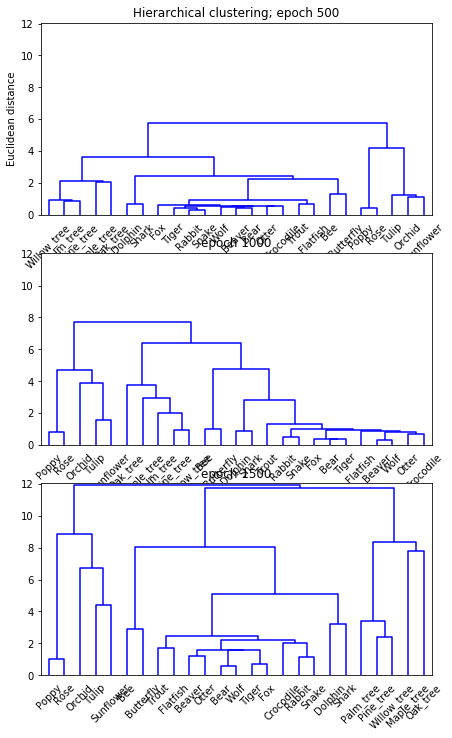

In [0]:
plot_dendo(rep1,rep2,rep3,names_items)

In [60]:
def train(mynet,epoch_count,nepochs_additional=100):
    # Input
    #  mynet : Net class object
    #  epoch_count : (scalar) how many epochs have been completed so far
    #  nepochs_additional : (scalar) how many more epochs we want to run
    dolphincan = np.zeros((6,nepochs_additional))
    animals = np.zeros((15,nepochs_additional,256))
    plants = np.zeros((10,nepochs_additional,256))
    fish = np.zeros((2,nepochs_additional,256))
    fish2 = np.zeros((2,nepochs_additional,256))
    for e in range(nepochs_additional): # for each epoch      
      error_epoch = 0.
      mynet.train()
      for batch_idx, (data,target) in enumerate(trainloader):
        t0 = time.time()
        data, target = torch.autograd.Variable(data), torch.autograd.Variable(target)
        data, target = data.cuda(), target.cuda()
        outputs, hidden, rep = mynet(data, target[:,:4])
        loss = criterion(outputs, target[:,4:])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        error_epoch += loss.item()
      mynet.eval()  
      for idx,(data, target) in enumerate(testloader):
        if idx == 52:
          data, target = torch.autograd.Variable(data), torch.autograd.Variable(target)
          data, target = data.cuda(), target.cuda()
          outputs, hidden, rep = mynet(data, target[:,:4])
          dolphincan[0,e] = np.mean(outputs.cpu().detach().numpy(),axis=0,keepdims=True)[0,39]
          dolphincan[1,e] = np.mean(outputs.cpu().detach().numpy(),axis=0,keepdims=True)[0,40]
          dolphincan[2,e] = np.mean(outputs.cpu().detach().numpy(),axis=0,keepdims=True)[0,41]
          dolphincan[3,e] = np.mean(outputs.cpu().detach().numpy(),axis=0,keepdims=True)[0,42]
          dolphincan[4,e] = np.mean(outputs.cpu().detach().numpy(),axis=0,keepdims=True)[0,43]
          dolphincan[5,e] = np.mean(outputs.cpu().detach().numpy(),axis=0,keepdims=True)[0,44]
        if idx in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]:
          data, target = torch.autograd.Variable(data), torch.autograd.Variable(target)
          data, target = data.cuda(), target.cuda()
          outputs, hidden, rep = mynet(data, target[:,:4])
          animals[idx,e,:] = np.mean(rep.cpu().detach().numpy(),axis=0,keepdims=True)
        if idx in [15,16,17,18,19,20,21,22,23,24]:
          data, target = torch.autograd.Variable(data), torch.autograd.Variable(target)
          data, target = data.cuda(), target.cuda()
          outputs, hidden, rep = mynet(data, target[:,:4])
          plants[idx-15,e,:] = np.mean(rep.cpu().detach().numpy(),axis=0,keepdims=True)
        if idx in [3,4]:
          data, target = torch.autograd.Variable(data), torch.autograd.Variable(target)
          data, target = data.cuda(), target.cuda()
          outputs, hidden, rep = mynet(data, target[:,:4])
          fish[idx-3,e,:] = np.mean(rep.cpu().detach().numpy(),axis=0,keepdims=True)
        if idx in [2,5]:
          data, target = torch.autograd.Variable(data), torch.autograd.Variable(target)
          data, target = data.cuda(), target.cuda()
          outputs, hidden, rep = mynet(data, target[:,:4])
          if idx == 2:
            fish2[idx-2,e,:] = np.mean(rep.cpu().detach().numpy(),axis=0,keepdims=True)
          if idx == 5:
            fish2[idx-4,e,:] = np.mean(rep.cpu().detach().numpy(),axis=0,keepdims=True)  
      print('epoch ' + str(epoch_count+e) + ' loss ' + str(round(error_epoch,3)))
      print('time taken for the epoch ' + str(round((time.time()-t0),3)))
    return epoch_count + nepochs_additional, dolphincan, plants, animals, fish, fish2

learning_rate = 0.1
criterion = nn.MSELoss() # mean squared error loss function
mynet = AlexNet(num_hidden = 512).cuda()
optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate) # stochastic gradient descent

nepochs_phase1 = 3000
nepochs_phase2 = 1000
nepochs_phase3 = 1500
#nepochs_phase4 = 200
#nepochs_phase5 = 250

epoch_count = 0
epoch_count, beavercan, plants, animals, fish, fish2 = train(mynet,epoch_count,nepochs_additional=nepochs_phase1)
#rep1 = get_rep(mynet)
#epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase2-nepochs_phase1)
#rep2 = get_rep(mynet)
#epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase3-nepochs_phase2)
#rep3 = get_rep(mynet)
#epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase4-nepochs_phase3)
#rep4 = get_rep(mynet)
#epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase5-nepochs_phase4)
#rep5 = get_rep(mynet)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0 loss 39.765
time taken for the epoch 0.691
epoch 1 loss 34.461
time taken for the epoch 0.691
epoch 2 loss 19.543
time taken for the epoch 0.687
epoch 3 loss 7.184
time taken for the epoch 0.689
epoch 4 loss 7.122
time taken for the epoch 0.684
epoch 5 loss 7.095
time taken for the epoch 0.684
epoch 6 loss 7.074
time taken for the epoch 0.702
epoch 7 loss 7.055
time taken for the epoch 0.752
epoch 8 loss 7.038
time taken for the epoch 0.746
epoch 9 loss 7.023
time taken for the epoch 0.696
epoch 10 loss 7.009
time taken for the epoch 0.695
epoch 11 loss 6.993
time taken for the epoch 0.69
epoch 12 loss 6.978
time taken for the epoch 0.75
epoch 13 loss 6.962
time taken for the epoch 0.692
epoch 14 loss 6.945
time taken for the epoch 0.695
epoch 15 loss 6.929
time taken for the epoch 0.705
epoch 16 loss 6.911
time taken for the epoch 0.758
epoch 17 loss 6.893
time taken for the epoch 0.766
epoch 18 loss 6.874
time taken for the epoch 0.706
epoch 19 loss 6.855
time taken for the e

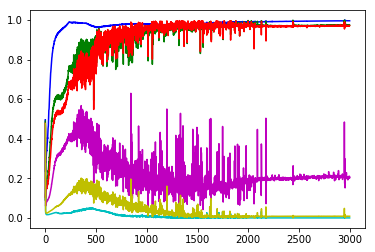

In [61]:
plt.plot(beavercan[0,:],'b')
plt.plot(beavercan[1,:],'g')
plt.plot(beavercan[2,:],'r')
plt.plot(beavercan[3,:],'c')
plt.plot(beavercan[4,:],'m')
plt.plot(beavercan[5,:],'y')

In [0]:
bb = np.mean(plants, axis = 0)

In [1]:
plt.plot(beavercan[0,:],'b')
plt.plot(beavercan[1,:],'g')
plt.plot(beavercan[2,:],'r')
plt.plot(beavercan[3,:],'c')
plt.plot(beavercan[4,:],'m')
plt.plot(beavercan[5,:],'y')

NameError: ignored

In [0]:
cc = np.mean(animals, axis = 0)

In [65]:
cc.shape

(3000, 256)

In [0]:
dist = np.linalg.norm(bb-cc, axis = 1,keepdims=True)
dist2 = np.linalg.norm(fish[0,:,:]-fish[1,:,:],axis = 1, keepdims = True)
dist3 = np.linalg.norm(fish2[0,:,:]-fish2[1,:,:],axis = 1, keepdims = True)

In [0]:
bb = np.mean(plants, axis = 0)
cc = np.mean(animals, axis = 0)
dd = np.mean(fish, axis = 0)
gg = np.mean(fish2, axis = 0)
dist = np.linalg.norm(bb-cc, axis = 1,keepdims=True)
dist2 = np.linalg.norm(cc-dd,axis = 1, keepdims = True)
dist3 = np.linalg.norm(bb-dd,axis = 1, keepdims = True)

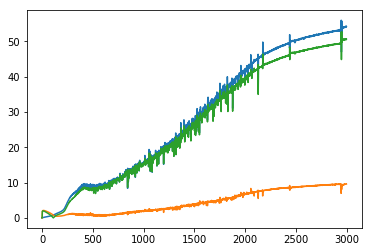

In [70]:
plt.plot(dist)
plt.plot(dist2)
plt.plot(dist3)

In [55]:
rep1 = get_rep(mynet)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(25, 256)


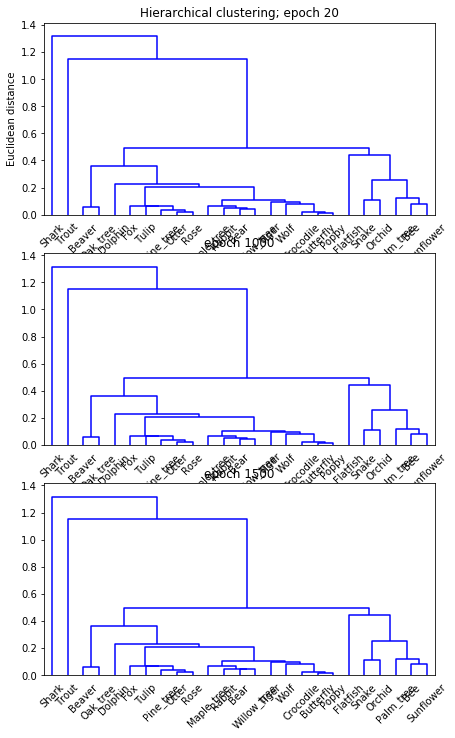

In [56]:
plot_dendo(rep1,rep1,rep1,names_items)